Total Profit from the strategy: 20003.101960516862
For z-score threshold 2:
Average duration: 0 hours, 45 minutes, and 12 seconds


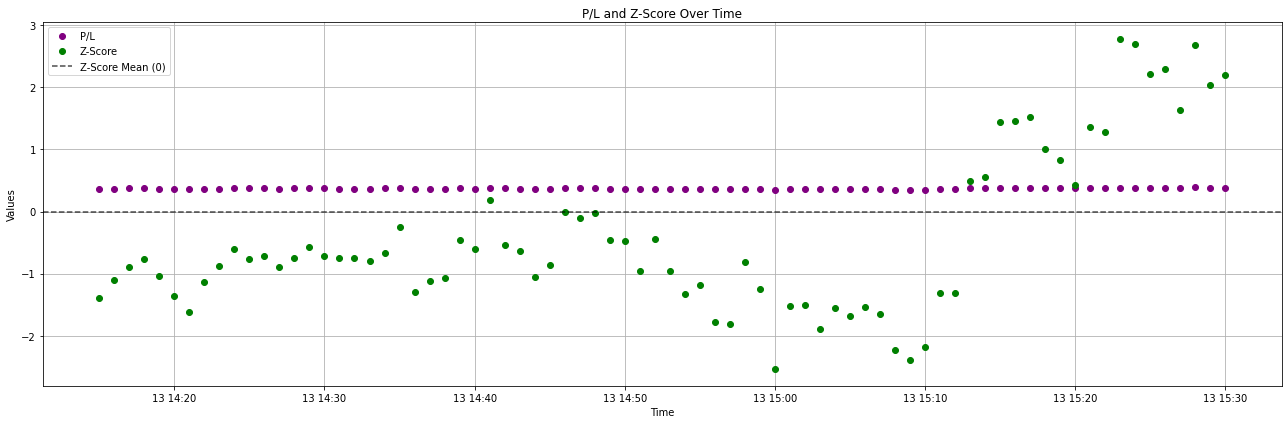

In [11]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

parquet_path = "C:/Users/jobin/Downloads/data.parquet"
zscore_threshold = 2
# Define working hours (09:15 to 15:30)
start_of_day = pd.to_datetime('09:15:00', format='%H:%M:%S')
end_of_day = pd.to_datetime('15:30:00', format='%H:%M:%S')

# Fixed duration of working hours in seconds (6 hours 15 minutes)
working_day_seconds = (end_of_day - start_of_day).total_seconds()
start_of_day = start_of_day.time()
end_of_day = end_of_day.time()

# Read the Parquet file
df = pd.read_parquet(parquet_path, engine='pyarrow')

# Calculate spread and P/L
df['spread'] = df['banknifty'] - df['nifty']
df['P/L'] = df['spread'] * (df['tte']**0.7)

# Compute rolling mean and std for spread, then calculate z-score
window = 100  # Rolling window size (in terms of data points)
df['spread_mean'] = df['spread'].rolling(window=window).mean()
df['spread_std'] = df['spread'].rolling(window=window).std()
df['z-score'] = (df['spread'] - df['spread_mean']) / df['spread_std']

# Drop rows with NaN values
df.dropna(inplace=True)

# Plot the P/L and z-score for the specified time range
plt.figure(figsize=(18, 6))

# Plot P/L (purple markers)
plt.plot(df.loc['2021-07-13 14:15:00':'2021-07-13 15:30:00', 'P/L'], linestyle='None', label='P/L', marker='o', color='purple')

# Plot z-score (green markers)
plt.plot(df.loc['2021-07-13 14:15:00':'2021-07-13 15:30:00', 'z-score'], linestyle='None', label='Z-Score', marker='o', color='green')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('P/L and Z-Score Over Time')

# Add horizontal line for z-score mean (0)
plt.axhline(0, color='black', linestyle='--', alpha=0.7, label='Z-Score Mean (0)')

# Add legend
plt.legend(loc='upper left')

# Enable grid for better readability
plt.grid(True)

# Optimize layout and show plot
plt.tight_layout()
#plt.show()

def calculate_strategy_profit(df):
    # Initialize variables
    sum_flag = abs(df['z-score'].iloc[0]) > zscore_threshold  # Start summing if the first z-score is > 2 in absolute value
    sum_periods = []
    
    # Extract z-scores and P/L for efficiency
    z_scores = df['z-score'].values
    pl_values = df['P/L'].values
    index_list = df.index.tolist()
    
    # Initialize total_profit based on the first z-score condition
    period_profit = pl_values[0] if sum_flag else 0.0
    start_time = index_list[0]
    # Iterate over rows in the DataFrame starting from index 1 (since we compare with previous z-score)
    for i in range(1, len(df)):
        z_score = z_scores[i]
        pl = pl_values[i]
        last_z_score = z_scores[i - 1]
        # Detect zero crossing or reversal condition
        if sum_flag:
            period_profit += pl
            if z_score == 0 or z_score * last_z_score < 0:
                sum_periods.append((start_time, index_list[i], period_profit))
                period_profit = 0.0
                sum_flag = False  # Close position if z-score hits zero or crosses sign
        else:
            if abs(z_score) > zscore_threshold:
                sum_flag = True  # Open position if z-score exceeds threshold or crosses sign
                start_time = index_list[i]
                period_profit += pl
    return sum_periods

# Function to calculate the duration between start and end times across multiple days
def calculate_duration(row):
    start, end = row['start'], row['end']
    
    # Initialize total duration in seconds
    total_seconds = 0
    
    # If the start and end are on the same day, calculate duration directly
    if start.date() == end.date():
        # Adjust start time to 09:15 if earlier than that
        if start.time() < start_of_day:
            start = start.replace(hour=9, minute=15, second=0)
        # Adjust end time to 15:30 if later than that
        if end.time() > end_of_day:
            end = end.replace(hour=15, minute=30, second=0)
        
        # Calculate the duration in seconds
        total_seconds += (end - start).total_seconds()
        return total_seconds
    
    # Handle the first day (adjust to start from 09:15)
    first_day_start = max(start.replace(hour=9, minute=15, second=0), start)
    first_day_end = start.replace(hour=15, minute=30, second=0)
    total_seconds += (first_day_end - first_day_start).total_seconds()

    # Handle the last day (adjust to end at 15:30)
    last_day_start = end.replace(hour=9, minute=15, second=0)
    last_day_end = min(end.replace(hour=15, minute=30, second=0), end)
    total_seconds += (last_day_end - last_day_start).total_seconds()
    
    # Calculate full days in between (09:15 to 15:30 for each full day)
    full_days = pd.date_range(start=start.date() + pd.Timedelta(days=1), end=end.date() - pd.Timedelta(days=1), freq='B')
    for day in full_days:
        total_seconds += working_day_seconds 
    return total_seconds

# Example usage
# Assuming df contains 'z_score', 'Spread', and 'tte' columns
sum_periods = calculate_strategy_profit(df)
durations = [(end - start).total_seconds() for start, end, _ in sum_periods]
total_profit = sum([row[-1] for row in sum_periods])
print("Total Profit from the strategy: {}".format(total_profit))

df = pd.DataFrame(
    [(start, end) for (start, end, _) in sum_periods]
    , columns=['start', 'end'],
    )
df['duration_seconds'] = df.apply(calculate_duration, axis=1)
# Calculate the average duration (in seconds)
average_duration_seconds = df['duration_seconds'].mean()

# Convert the average duration to a more readable format (e.g., hours and minutes)
average_duration = divmod(average_duration_seconds, 3600)  # Get hours and remainder in seconds
average_duration_minutes = divmod(average_duration[1], 60)  # Get minutes and remainder in seconds

# Display the results
print(f"For z-score threshold {zscore_threshold}:")
print(f"Average duration: {int(average_duration[0])} hours, ", end="")
print(f"{int(average_duration_minutes[0])} minutes, ", end="")
print(f"and {int(average_duration_minutes[1])} seconds")

In this project, I implemented a trading strategy based on the z-score of the spread between Nifty and BankNifty indices. Trades are triggered when the z-score exceeds ±2 and are reverted when it crosses back to 0. The P/L equation was used to compute profits, but I couldn't fully understand its rationale or how to properly apply it for a single pair trade. Profit is calculated by summing the P/L during the duration of a trade (I don't know is that the correct way). Additionally, I analyzed the duration of trades and calculated the average time taken for z-scores to return to zero after exceeding the threshold. For a z-score threshold of 2, the average duration of trades is 0 hours, 45 minutes, and 12 seconds, consistent with the medium-frequency horizon of 30 minutes to 5 days. A better understanding of P/L is essential to effectively build an improved trading model and optimize key performance metrics such as absolute P/L, Sharpe Ratio, and Drawdown.